# Convolutional networks - Illustration

In this practice session, we implement and optimise a simple convolutional network to recognise handwritten digits.

In [24]:
# Modules
import numpy as np
import pydot # Requires installation
import pickle

from matplotlib import pyplot
from tensorflow.keras import callbacks, datasets, initializers, layers, losses, models, optimizers, preprocessing, utils
from scipy import ndimage
from skimage import data, transform, util
from sklearn import metrics

In [25]:
# Utilities

def display(image:np.ndarray, title:str='', cmap:str='gray', figsize=(5, 5)) -> None:
    '''Displays an image'''
    fig, ax = pyplot.subplots(1, figsize=figsize)
    ax.imshow(image, cmap=cmap)
    ax.set_title(title, fontsize=20)
    ax.set_axis_off()
    pyplot.tight_layout()
    pyplot.show()

def compare(images:list, titles:list, cmap='gray', gridsize=(1, 2), figsize=(5, 5)) -> None:
    '''Displays multiple images'''
    fig, axs = pyplot.subplots(nrows=gridsize[0], ncols=gridsize[1], figsize=(figsize[1]*gridsize[1], figsize[0]*gridsize[0]))
    for ax, image, title in zip(axs.ravel(), images, titles):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title, fontsize=20)
        ax.set_axis_off()
    pyplot.tight_layout()
    pyplot.show()

1. Load the grayscale image `skimage.data.camera()` of dimensions $h \times w$ resize it to $100 \times 100$ (see `transform.resize`) and display the result.

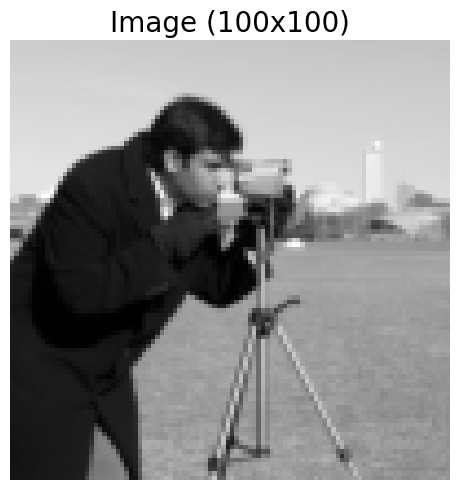

In [26]:
# Loads and displays image
image = data.camera()
image = transform.resize(image, output_shape=(100, 100))
display(image, title='Image (100x100)')

2. Using a `np.array`, initialise a $3 \times 3$ kernel containing a Sobel operator for edge detection (i.e. horizontal or vertical), perform a convolution on the resized image (see `ndimage.convolve`). Display and explain the results.

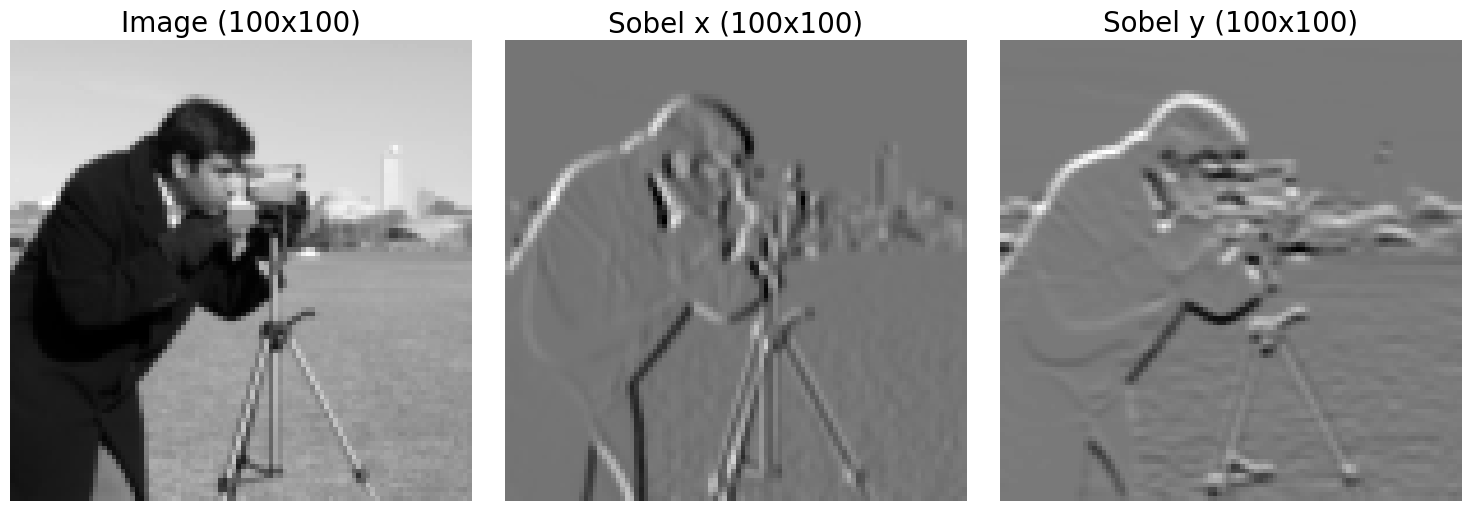

In [27]:
# Convolution
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # Sobel filter
convolution1 = ndimage.convolve(image, kernel)
convolution2 = ndimage.convolve(image, kernel.T)

# Displays results
compare(images=[image, convolution1, convolution2], titles=['Image (100x100)', 'Sobel x (100x100)', 'Sobel y (100x100)'], gridsize=(1,3))

3. Implement manually ReLU activation (see `np.maximum`) and $2 \times 2$ maximum pooling on the convolution output (see `skimage.util.view_as_blocks`). Display and explain the results.

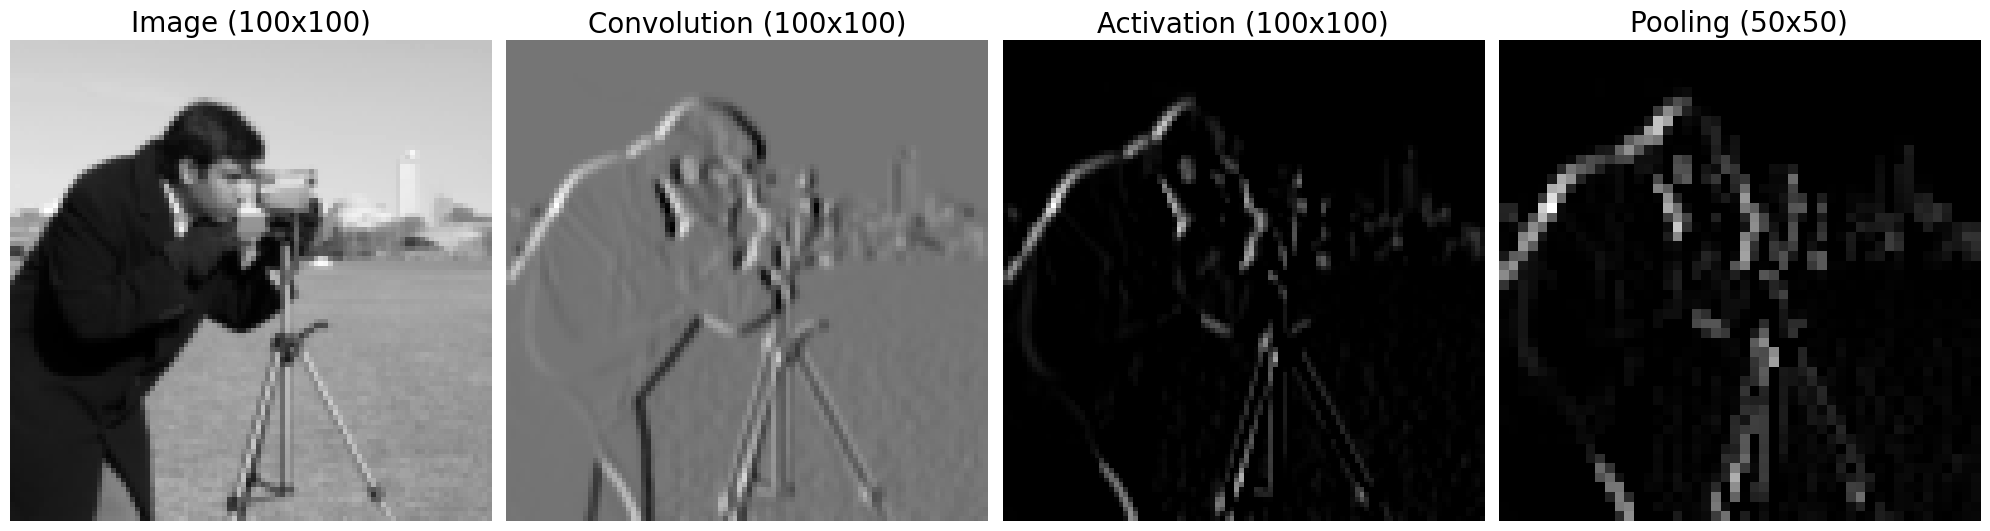

In [28]:
# Activation and pooling
activation  = np.maximum(convolution1, 0) 
pooling     = np.max(util.view_as_blocks(activation, (2, 2)), axis=(2, 3))

# Displays results
compare(images=[image, convolution1, activation, pooling], 
        titles=['Image (100x100)', 'Convolution (100x100)', 'Activation (100x100)', 'Pooling (50x50)'], 
        gridsize=(1, 4), figsize=(20, 5))

4. Load the MNIST dataset (see `keras.datasets.mnist.load_data`). Format the input as a $n \times h^{(0)} \times w^{(0)} \times d^{(0)}$ dimensional array (see `np.expand_dims`). The resulting array should have dimensions $n \times 28 \times 28 \times 1$ and type `float`.

In [29]:
# Loads dataset
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Formats input
X_train = np.expand_dims(X_train, 3).astype(float)
X_test  = np.expand_dims(X_test,  3).astype(float)

5. Normalise the pixel intensities over the $[-1.0;1.0]$ range for each channel. Format the target array with dimensions $n \times k^{(L)}$ array where $k^{(L)}=10$ is the number of output classes (see `keras.utils.to_categorical`).

In [30]:
# Normalises inputs
X_train = X_train / 127.5 - 1
X_test  = X_test  / 127.5 - 1

# Formats target
y_train = utils.to_categorical(y_train, 10)
y_test  = utils.to_categorical(y_test,  10)

6. Using the `keras` functional API, build the LeNet5 model structure (i.e. see lecture notes, `layers.Conv2D`, `layers.MaxPooling2D`) with `relu` activation for the hidden layers and the appropriate activation for the output layer. Choose the correct parameter initialisation technique. Use the `summary` method of the model to visualise its structure (alternatively, you can use `keras.utils.plot_model`).

Note: Don't forget to flatten the representation between the convolutional and the dense layers (see `layers.Flatten`).

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer1 (Conv2D)        (None, 28, 28, 6)         156       
                                                                 
 pool_layer1 (MaxPooling2D)  (None, 14, 14, 6)         0         
                                                                 
 conv_layer2 (Conv2D)        (None, 10, 10, 16)        2416      
                                                                 
 pool_layer2 (MaxPooling2D)  (None, 5, 5, 16)          0         
                                                                 
 flatten_layer (Flatten)     (None, 400)               0         
                                                                 
 dense_layer1 (Dense)        (None, 120)               48120

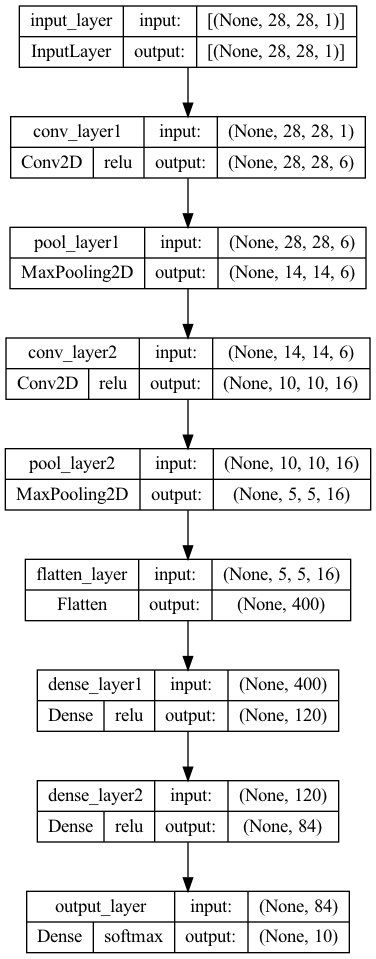

In [31]:
''' Note:
- For consitency, we use `padding=same` for the first convolutional layer (the input size in the original paper is $32 \times 32$).
- He et al. (2015) intialisation is designed for ReLU.
'''

def build_model(input_shape:tuple, n_outputs:int):
  '''Initialise LeNet5 model structure'''
  initializer = initializers.HeNormal(seed=0)
  inputs  = layers.Input(shape=input_shape, name='input_layer')
  hidden  = layers.Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer=initializer, name='conv_layer1')(inputs)
  hidden  = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='pool_layer1')(hidden)
  hidden  = layers.Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='relu', kernel_initializer=initializer, name='conv_layer2')(hidden)
  hidden  = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='pool_layer2')(hidden)
  hidden  = layers.Flatten(name='flatten_layer')(hidden)
  hidden  = layers.Dense(units=120, activation='relu', kernel_initializer=initializer, name='dense_layer1')(hidden)
  hidden  = layers.Dense(units=84,  activation='relu', kernel_initializer=initializer, name='dense_layer2')(hidden)
  outputs = layers.Dense(units=n_outputs,  activation='softmax', kernel_initializer=initializer, name='output_layer')(hidden)
  model   = models.Model(inputs=inputs, outputs=outputs, name='LeNet5')
  return model

# Builds model
model = build_model(input_shape=(28, 28, 1), n_outputs=10)

# Displays model structure
model.summary()
utils.plot_model(model, to_file='/Users/goclem/Desktop/model.png', show_shapes=True, show_layer_activations=True)

7. Compile and the model using an appropriate loss function and optimiser. Estimate the parameters on the training sample using a maximum of 10 epoch (or less depending on your computer). You may implement early stopping to prevent overfitting (see `keras.callbacks`) with a validation sample of 20%.

8. Display the optimisation path for the training and the validation samples. Compute the predictive performance on the test sample and display the confusion matrix. Which portion of the test sample is correcly classified?

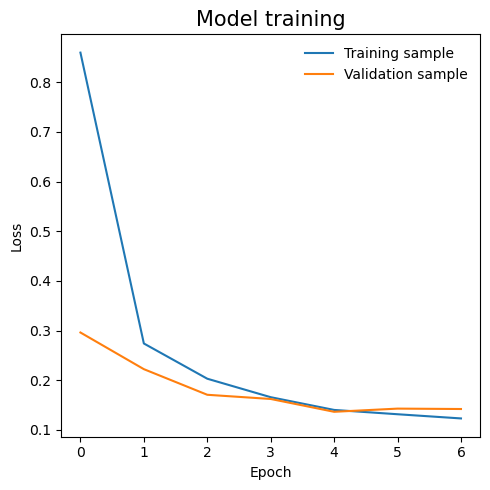

2023-11-06 17:11:00.486267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 14s 43ms/step - loss: 0.1274 - accuracy: 0.9620
Test loss:     0.1274
Test accuracy: 0.9620
  1/313 [..............................] - ETA: 1:04

2023-11-06 17:11:14.563601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


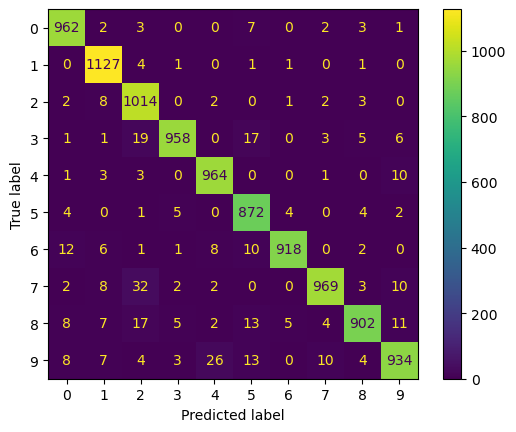

In [32]:
# Loads model and history
model = models.load_model('convolutional_model.h5')
with open('convolutional_model.pkl', 'rb') as file:
    history = pickle.load(file)

# Plots optimisation path
display_history(history, validation=True)

# Prediction scores
scores = dict(zip(['loss', 'accuracy'], model.evaluate(X_test, y_test)))
print('Test loss:     {loss:0.4f}\nTest accuracy: {accuracy:0.4f}'.format(**scores))
# Test loss:     0.1421
# Test accuracy: 0.9653

# Confusion matrix
yh_test = model.predict(X_test)
confmat = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yh_test, axis=1))
confmat = metrics.ConfusionMatrixDisplay(confusion_matrix=confmat)
confmat.plot()